### DSPT6 - Adding Data Science to a Web Application

The purpose of this notebook is to demonstrate:
- Simple online analysis of data from a user of the Twitoff app or an API
- Train a more complicated offline model, and serialize the results for online use

In [1]:
import sqlite3
import pickle
import pandas as pd

In [2]:
# Connect to sqlite database
conn = sqlite3.connect('../twitoff/twitoff.sqlite')

In [3]:
def get_data(query, conn):
    '''Function to get data from SQLite DB'''
    
    cursor = conn.cursor()
    result = cursor.execute(query).fetchall()

    # Get columns from cursor object
    columns = list(map(lambda x: x[0], cursor.description))

    # Assign to DataFrame
    df = pd.DataFrame(data=result, columns=columns)
    return df

In [14]:
query = '''
SELECT 
  tweet.id,
  tweet.text, 
  tweet.embedding,
  user.username
FROM tweet
JOIN user ON tweet.user_id = user.id
'''

df = get_data(query, conn)
df['embedding_decoded'] = df.embedding.apply(lambda x: pickle.loads(x[2:]))
print(df.shape)
df.head()

(14163, 5)


,id,text,embedding,username,embedding_decoded
0,1291784200178159616,Good piece on Giga Berlin construction https:/...,b'\x80\x04\x95\x05\x1b\x00\x00\x00\x00\x00\x00...,elonmusk,"[-0.302523, -0.402071, 1.31735, -1.08965, 1.12..."
1,1291504220948951041,SN5 https://t.co/GlZ28KFVHU,b'\x80\x04\x95\x05\x1b\x00\x00\x00\x00\x00\x00...,elonmusk,"[0.0428416, -0.375493, 1.57613, -0.605883, 1.1..."
2,1290056061253165057,When space travel becomes as common as air tra...,b'\x80\x04\x95\x05\x1b\x00\x00\x00\x00\x00\x00...,elonmusk,"[-0.175182, -0.14762, 0.771897, -0.335885, 1.1..."
3,1290021404994236416,Congratulations @SpaceX &amp; @NASA on complet...,b'\x80\x04\x95\x05\x1b\x00\x00\x00\x00\x00\x00...,elonmusk,"[-0.566924, 0.134408, 0.45648, -0.165182, 0.03..."
4,1289997160763670530,Dragon is stable in the water,b'\x80\x04\x95\x05\x1b\x00\x00\x00\x00\x00\x00...,elonmusk,"[-0.618478, -0.0443067, 1.2989, -1.19803, 1.29..."


In [6]:
df.username.value_counts()

theeconomist    3105
techcrunch      3097
billgates       2882
barackobama     2764
nasa            1680
elonmusk         409
jeffbezos        226
Name: username, dtype: int64

In [52]:
import numpy as np

user1 = 'elonmusk'
user2 = 'nasa'

user1_embeddings = df.embedding_decoded[df.username==user1]
user2_embeddings = df.embedding_decoded[df.username==user2]
embeddings = pd.concat([user1_embeddings, user2_embeddings])

embeddings_df = pd.DataFrame(embeddings.to_list(), 
                             columns=[f'dim{i}' for i in range(768)])
labels = np.concatenate([np.ones(len(user1_embeddings)),
                         np.zeros(len(user2_embeddings))])
print(embeddings_df.shape, labels.shape)

(2089, 768) (2089,)


In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    embeddings_df, labels, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape)

(1566, 768) (523, 768)


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       416
         1.0       0.99      0.98      0.99       107

    accuracy                           0.99       523
   macro avg       0.99      0.99      0.99       523
weighted avg       0.99      0.99      0.99       523



c:\users\bruno\.virtualenvs\twitoff-dspt6-test-9pff9vts\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


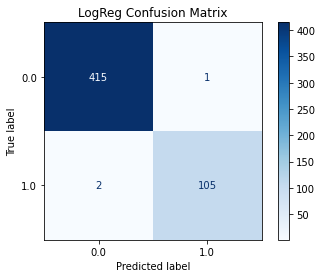

In [72]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

plot_confusion_matrix(log_reg, X_test, y_test, cmap='Blues')
plt.title('LogReg Confusion Matrix');

In [ ]:
tweet_embedding = BASILICA.embed_sentence(tweet_text, model='twitter')